In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os, glob

BASE_DIR = "/content/drive/MyDrive/DDOS"
DATA_DIR = os.path.join(BASE_DIR, "data/archive")
OUT_DIR  = os.path.join(BASE_DIR, "model_output/num1/deep_model_output")
os.makedirs(OUT_DIR, exist_ok=True)

KERAS_MODEL_DIR = os.path.join(OUT_DIR, "ddos_nn_keras")
META_PATH = os.path.join(OUT_DIR, "ddos_nn_meta.joblib")
PRED_CSV = os.path.join(OUT_DIR, "test_predictions.csv")

BATCH_SIZE = 1024
MAX_EPOCHS = 400
PATIENCE = 20
INITIAL_LR = 1e-4
SAMPLE_FRAC_PER_FILE = 1.0
SEED = 42

print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUT_DIR}")


DATA_DIR: /content/drive/MyDrive/DDOS/data/archive
OUTPUT_DIR: /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output


In [17]:
!pip install -q scikit-learn pandas pyarrow joblib imbalanced-learn tensorflow

import warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, auc, f1_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

import joblib
import matplotlib.pyplot as plt

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [18]:
parquets = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
csvs = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
all_files = parquets + csvs

print("Found files:", len(all_files))
for p in all_files[:20]:
    print(" -", os.path.basename(p))
if len(all_files) > 20:
    print(" ... ({} more)".format(len(all_files)-20))

def is_training(path): return "training" in os.path.basename(path).lower()
def is_testing(path):  return "testing" in os.path.basename(path).lower()

ATTACK_KEYS = ['syn','udp','udplag','dns','ntp','snmp','tftp','ldap','mssql','netbios','portmap','ssdp']

def infer_attack_type(fname: str) -> str:
    n = os.path.basename(fname).lower()
    for k in ATTACK_KEYS:
        if k in n:
            return k.upper()
    return "BENIGN/UNKNOWN"

def infer_label_col(df: pd.DataFrame):
    for cand in ['label','Label','attack','is_attack','y','target','__label__']:
        if cand in df.columns:
            return cand
    return None

def load_and_label(path: str, assume_attack=True, sample_frac=None) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".parquet":
        df = pd.read_parquet(path)
        if sample_frac is not None and sample_frac < 1.0:
            df = df.sample(frac=sample_frac, random_state=SEED)
    else:
        if sample_frac is None or sample_frac >= 1.0:
            df = pd.read_csv(path)
        else:
            chunks = []
            for chunk in pd.read_csv(path, chunksize=200_000):
                chunks.append(chunk.sample(frac=sample_frac, random_state=SEED))
            df = pd.concat(chunks, ignore_index=True)

    labcol = infer_label_col(df)
    if labcol is not None:
        df['__label__'] = df[labcol].apply(lambda v: 1 if str(v).lower() not in ('0','benign','normal','false') else 0)
    else:
        atk = infer_attack_type(path)
        df['__label__'] = 0 if atk == "BENIGN/UNKNOWN" else (1 if assume_attack else 0)

    df['__attack_type__'] = infer_attack_type(path)
    df['__src_file__'] = os.path.basename(path)
    return df


Found files: 17
 - DNS-testing.parquet
 - LDAP-testing.parquet
 - LDAP-training.parquet
 - MSSQL-testing.parquet
 - MSSQL-training.parquet
 - NTP-testing.parquet
 - NetBIOS-testing.parquet
 - NetBIOS-training.parquet
 - Portmap-training.parquet
 - SNMP-testing.parquet
 - Syn-testing.parquet
 - Syn-training.parquet
 - TFTP-testing.parquet
 - UDP-testing.parquet
 - UDP-training.parquet
 - UDPLag-testing.parquet
 - UDPLag-training.parquet


In [19]:
train_dfs, test_dfs = [], []

for p in all_files:
    try:
        if is_training(p):
            df = load_and_label(p, assume_attack=True, sample_frac=SAMPLE_FRAC_PER_FILE)
            train_dfs.append(df)
        elif is_testing(p):
            df = load_and_label(p, assume_attack=True, sample_frac=SAMPLE_FRAC_PER_FILE)
            test_dfs.append(df)
        else:
            df = load_and_label(p, assume_attack=True, sample_frac=SAMPLE_FRAC_PER_FILE)
            train_dfs.append(df)
    except Exception as e:
        print("Failed to load", p, e)

train_df = pd.concat(train_dfs, ignore_index=True) if train_dfs else pd.DataFrame()
test_df  = pd.concat(test_dfs,  ignore_index=True) if test_dfs  else pd.DataFrame()

print("Train shape:", train_df.shape)
print(train_df['__label__'].value_counts(normalize=True) if '__label__' in train_df.columns else "No label in train")
print("Test  shape:", test_df.shape)
print(test_df['__label__'].value_counts(normalize=True) if ('__label__' in test_df.columns and not test_df.empty) else "No/empty test")

if not train_df.empty and train_df['__label__'].nunique() == 1:
    print("[WARN] Train has single label. Generating synthetic benign samples...")
    n_needed = int(len(train_df) * 0.5)
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    for col in ['__label__']:
        if col in numeric_cols:
            numeric_cols.remove(col)
    benign = train_df[numeric_cols].sample(n=n_needed, replace=True, random_state=SEED).copy()
    for col in ['packet_count','packets_per_sec','Flow Bytes/s','Flow Packets/s','flow_bps','byte_count','Total Fwd Packets','Total Backward Packets']:
        if col in benign.columns:
            benign[col] = (benign[col] * np.random.uniform(0.01,0.2,size=len(benign))).astype(np.float32)
    benign_df = pd.DataFrame(columns=train_df.columns)
    for c in benign.columns:
        if c in benign_df.columns:
            benign_df[c] = benign[c]
    benign_df['__label__'] = 0
    benign_df['__attack_type__'] = 'BENIGN/SYNTH'
    benign_df['__src_file__'] = 'synthetic_benign'
    for c in train_df.columns:
        if c not in benign_df.columns:
            benign_df[c] = 0
    train_df = pd.concat([train_df, benign_df[train_df.columns]], ignore_index=True)
    print("After benign augmentation:", train_df.shape)


Train shape: (125170, 81)
__label__
1    0.629088
0    0.370912
Name: proportion, dtype: float64
Test  shape: (306201, 81)
__label__
1    0.832123
0    0.167877
Name: proportion, dtype: float64


In [20]:
assert not train_df.empty, "train_df is empty. Check DATA_DIR or file patterns."

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
for drop in ['__label__','__attack_type__','__src_file__','index','flow_id','id']:
    if drop in numeric_cols:
        numeric_cols.remove(drop)
for tcol in ['Time','Timestamp','StartTime','flow_start_time']:
    if tcol in numeric_cols:
        numeric_cols.remove(tcol)

FEATURES = numeric_cols
print(f"[INFO] Using {len(FEATURES)} features:", FEATURES[:20])

X_all = train_df[FEATURES].fillna(0).astype(np.float32).values
y_all = train_df['__label__'].astype(np.int32).values

# 테스트셋 준비
if not test_df.empty and '__label__' in test_df.columns:
    for f in FEATURES:
        if f not in test_df.columns:
            test_df[f] = 0
    X_test = test_df[FEATURES].fillna(0).astype(np.float32).values
    y_test = test_df['__label__'].astype(np.int32).values
else:
    X_test, y_test = None, None

# 명시적 검증분리 (threshold 튜닝용)
X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=SEED
)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_raw)
X_val = scaler.transform(X_val_raw)
if X_test is not None:
    X_test = scaler.transform(X_test)

print("Shapes -> train:", X_tr.shape, "val:", X_val.shape, "test:", None if X_test is None else X_test.shape)


[INFO] Using 77 features: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min']
Shapes -> train: (100136, 77) val: (25034, 77) test: (306201, 77)


In [21]:
classes = np.unique(y_tr)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("[INFO] class_weights:", class_weights)

def build_model(input_dim, lr=INITIAL_LR, wd=1e-4, dp1=0.4, dp2=0.3, dp3=0.2):
    reg = regularizers.l2(wd)
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation='relu', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(dp1),

        layers.Dense(512, activation='relu', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(dp2),

        layers.Dense(256, activation='relu', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(dp3),

        layers.Dense(1, activation='sigmoid')
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return model

model = build_model(X_tr.shape[1], lr=INITIAL_LR, wd=1e-4)
model.summary()


[INFO] class_weights: {0: 1.3480157234397716, 1: 0.7948058545258279}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,425 (2.84 MB)

 Trainable params: 739,841 (2.82 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [22]:
os.makedirs(KERAS_MODEL_DIR, exist_ok=True)
ckpt_path = os.path.join(KERAS_MODEL_DIR, "best_model.keras")

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=PATIENCE,
                            restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', patience=3,
                                factor=0.5, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_auc', mode='max',
                              save_best_only=True, verbose=1)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/400
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9058 - auc: 0.9504 - loss: 0.3476
Epoch 1: val_auc improved from -inf to 0.99796, saving model to /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output/ddos_nn_keras/best_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9064 - auc: 0.9509 - loss: 0.3462 - val_accuracy: 0.9887 - val_auc: 0.9980 - val_loss: 0.2704 - learning_rate: 1.0000e-04
Epoch 2/400
93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - auc: 0.9978 - loss: 0.1484
Epoch 2: val_auc improved from 0.99796 to 0.99905, saving model to /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output/ddos_nn_keras/best_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9929 - auc: 0.9978 - loss: 0.1482 - val_accuracy: 0.9925 - val_auc: 0.9991 - val_loss: 0.1651 - learning_rate: 1.0000e-04
Epoch 3/400
89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - auc: 0.9983 - loss: 0.1406
Epoch 3: val_auc improved fr

[INFO] Model saved to: /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output/ddos_nn_keras/final_model.keras
[INFO] Meta saved to : /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output/ddos_nn_meta.joblib


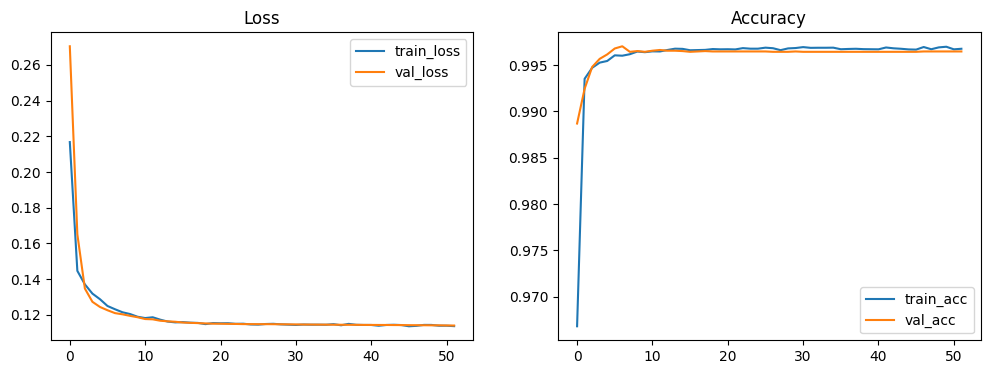

In [23]:
final_path = os.path.join(KERAS_MODEL_DIR, "final_model.keras")
model.save(final_path, include_optimizer=False)
joblib.dump({'scaler': scaler, 'features': FEATURES}, META_PATH)
print(f"[INFO] Model saved to: {final_path}")
print(f"[INFO] Meta saved to : {META_PATH}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history.history['loss'], label='train_loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss')
plt.subplot(1,2,2); plt.plot(history.history['accuracy'], label='train_acc'); plt.plot(history.history['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy')
plt.show()


In [24]:
val_proba = model.predict(X_val, batch_size=BATCH_SIZE).ravel()

ths = np.linspace(0.05, 0.95, 19)
best_f1, best_f1_thr = -1, 0.5
for th in ths:
    f1 = f1_score(y_val, (val_proba >= th).astype(int))
    if f1 > best_f1:
        best_f1, best_f1_thr = f1, th

fpr, tpr, thr = roc_curve(y_val, val_proba)
youden_thr = float(thr[np.argmax(tpr - fpr)])

print(f"[VAL] F1-opt thr={best_f1_thr:.3f} (F1={best_f1:.4f})")
print(f"[VAL] Youden-opt thr={youden_thr:.3f}")

opt_thr = float(best_f1_thr)

def eval_with_thresholds(X, y, proba, thresholds, tag="TEST"):
    for th in thresholds:
        pred = (proba >= th).astype(int)
        print(f"\n=== {tag} @ threshold={th:.3f} ===")
        print(classification_report(y, pred, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y, pred))

if X_test is not None:
    test_proba = model.predict(X_test, batch_size=BATCH_SIZE).ravel()
    print("\n[TEST] ROC AUC:", round(roc_auc_score(y_test, test_proba), 4))
    eval_with_thresholds(X_test, y_test, test_proba, [0.5, opt_thr], tag="TEST")

    y_pred_opt = (test_proba >= opt_thr).astype(int)
    test_df['_pred_']  = y_pred_opt
    test_df['_score_'] = test_proba
    test_df.to_csv(PRED_CSV, index=False)
    print(f"[INFO] Predictions saved to {PRED_CSV}")
else:
    print("[WARN] No test set — only validation metrics available.")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[VAL] F1-opt thr=0.400 (F1=0.9976)
[VAL] Youden-opt thr=0.891
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[TEST] ROC AUC: 0.9992

=== TEST @ threshold=0.500 ===
              precision    recall  f1-score   support

           0     0.9574    0.9919    0.9743     51404
           1     0.9983    0.9911    0.9947    254797

    accuracy                         0.9912    306201
   macro avg     0.9779    0.9915    0.9845    306201
weighted avg     0.9915    0.9912    0.9913    306201

Confusion matrix:
 [[ 50986    418]
 [  2270 252527]]

=== TEST @ threshold=0.400 ===
              precision    recall  f1-score   support

           0     0.9634    0.9914    0.9772     51404
           1     0.9983    0.9924    0.9953    254797

    accuracy                         0.9922    306201
   macro avg     0.9808    0.9919    0.9863    306201
weighted avg     0.9924    0.9922    0.9923    306201

Confusion matrix:
 [[ 50962    442]
 [  1937 252860]]
[INFO] 

In [25]:
if X_test is not None:
    fpr, tpr, _ = roc_curve(y_test, test_df['_score_'].values)
    prec, rec, _ = precision_recall_curve(y_test, test_df['_score_'].values)
    roc_auc = auc(fpr, tpr); pr_auc = auc(rec, prec)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (TEST)'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "roc_test.png")); plt.close()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f'PR AUC={pr_auc:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (TEST)'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "pr_test.png")); plt.close()

    print(f"[INFO] Saved ROC/PR plots to {OUT_DIR}")


[INFO] Saved ROC/PR plots to /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output


In [26]:
def infer_attack_type_from_name(name: str):
    n = name.lower()
    for k in ATTACK_KEYS:
        if k in n:
            return k.upper()
    return "BENIGN/UNKNOWN"

if not test_df.empty:
    if '__attack_type__' not in test_df.columns:
        test_df['__attack_type__'] = test_df['__src_file__'].apply(infer_attack_type_from_name)

    rows = []
    for atype, g in test_df.groupby('__attack_type__'):
        if '__label__' not in g.columns:
            continue
        yt = g['__label__'].values
        yp = g['_pred_'].values if '_pred_' in g.columns else None
        if yp is None or len(np.unique(yt)) < 2:
            continue
        rep = classification_report(yt, yp, output_dict=True)
        rows.append({
            'attack_type': atype,
            'support': len(g),
            'precision_1': rep['1']['precision'],
            'recall_1':    rep['1']['recall'],
            'f1_1':        rep['1']['f1-score']
        })
    if rows:
        per_attack_df = pd.DataFrame(rows).sort_values('f1_1', ascending=False)
        print(per_attack_df.to_string(index=False))
        per_attack_df.to_csv(os.path.join(OUT_DIR, "per_attack_report.csv"), index=False)
        print(f"[INFO] per-attack report saved: {os.path.join(OUT_DIR, 'per_attack_report.csv')}")
else:
    print("[INFO] No test_df for per-attack report.")


attack_type  support  precision_1  recall_1     f1_1
       TFTP   121833     0.998726  0.998868 0.998797
        SYN      907     0.996255  0.998124 0.997188
        UDP    24927     0.998392  0.994778 0.996582
      MSSQL     8083     0.993439  0.999356 0.996389
       SNMP     4018     0.987627  0.998896 0.993230
        NTP   134674     0.998833  0.987633 0.993201
       LDAP     2831     0.984900  0.996528 0.990680
    NETBIOS     2225     0.969055  0.994983 0.981848
        DNS     6703     0.992261  0.943581 0.967309
[INFO] per-attack report saved: /content/drive/MyDrive/DDOS/model_output/num1/deep_model_output/per_attack_report.csv


In [27]:
def permutation_importance_auc(model, X_ref, y_ref, feature_names, n_top=20, sample=20000, seed=SEED):
    rng = np.random.default_rng(seed)
    idx = np.arange(X_ref.shape[0])
    if len(idx) > sample:
        idx = rng.choice(idx, size=sample, replace=False)
    Xb = X_ref[idx].copy()
    yb = y_ref[idx].copy()

    base_proba = model.predict(Xb, batch_size=2048).ravel()
    base_auc = roc_auc_score(yb, base_proba)

    drops = []
    for j, f in enumerate(feature_names):
        Xp = Xb.copy()
        rng.shuffle(Xp[:, j])  # 해당 컬럼만 섞기
        proba = model.predict(Xp, batch_size=2048).ravel()
        auc_j = roc_auc_score(yb, proba)
        drops.append((f, float(base_auc - auc_j)))
    drops.sort(key=lambda x: x[1], reverse=True)
    return drops[:n_top]

top_imp = permutation_importance_auc(model, X_val, y_val, FEATURES, n_top=20, sample=20000)
print("\n[Top 20 Permutation Importances] (ΔAUC 기준)")
for f, d in top_imp:
    print(f"{f:32s}  ΔAUC={d:.5f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [28]:
def predict_flow_dict(flow_dict: dict, model_path=None, meta_path=None, threshold=0.5):
    mdl = model if model_path is None else tf.keras.models.load_model(model_path)
    meta = {'scaler': scaler, 'features': FEATURES} if meta_path is None else joblib.load(meta_path)
    sc = meta['scaler']; feats = meta['features']

    row = {f: float(flow_dict.get(f, 0.0)) for f in feats}
    X = pd.DataFrame([row], columns=feats).astype(np.float32).fillna(0).values
    Xs = sc.transform(X)
    score = float(mdl.predict(Xs)[0,0])
    pred = int(score >= threshold)
    return {'score': score, 'pred': pred, 'threshold': threshold}

if not test_df.empty:
    sample = test_df.iloc[0]
    sample_dict = {f: float(sample.get(f, 0.0)) for f in FEATURES}
    print("Sample predict:", predict_flow_dict(sample_dict, threshold=0.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Sample predict: {'score': 0.9997756481170654, 'pred': 1, 'threshold': 0.5}
